# Reading and Transforming the Dataset

In [11]:
import torch
import torchvision # provide access to datasets, models, transforms, utils, etc
import torchvision.transforms as transforms

train_set = torchvision.datasets.EMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,split = "balanced"
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

# Checking the dataset and distribution

In [46]:
print(len(train_set))
train_set.train_labels.bincount()

112800


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400,
        2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400, 2400])

# Check a single image

label: 45


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


(torch.Size([1, 28, 28]), 45)

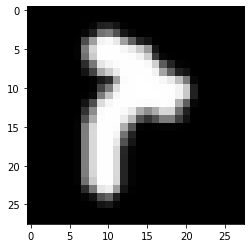

In [10]:
import matplotlib.pyplot as plt
sample = next(iter(train_set))
len(sample)
image, label = sample
plt.imshow(image.squeeze(), cmap='gray')
print('label:', label)
image.shape, label

# CNN Model

In [91]:
import torch.nn as nn
import torch.nn.functional as F
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding = 1) #28*28* 1 > 28* 28 10 # There will be max pool after conv1. After Max pool the recepetive field will be 6*6
        self.conv2 = nn.Conv2d(in_channels=10, out_channels= 10 , kernel_size=3, padding = 1) #14*14 *10 > 14 *14 10 # There will be max pool after conv2. After Max pool the recepetive field will be 16 *16
        self.conv3 = nn.Conv2d(in_channels=10, out_channels= 20 , kernel_size=3) # 7 * 7 * 10 >  5 * 5 * 20 # Cov3 Receptive field 18
        self.conv4 = nn.Conv2d(in_channels= 20, out_channels= 20 , kernel_size=3) # 5 *5 *20 > 3* 3* 20 # Cov4 Receptive field 20
        self.conv5 = nn.Conv2d(in_channels= 20, out_channels= 30 , kernel_size=3) # 3* 3* 20 > 1 * 1 * 30 # Cov5 Receptive field 22
        self.conv6 = nn.Conv2d(in_channels= 30, out_channels= 47 , kernel_size=1) # 3* 3* 20 > 1 * 1 * 30



    def forward(self, t):
      # (1) input layer
      t = t
       # (2) hidden conv layer
      t = self.conv1(t)
      t = F.relu(t)
      t = F.max_pool2d(t, kernel_size=2)

        # (3) hidden conv layer
      t = self.conv2(t)
      t = F.relu(t)
      t = F.max_pool2d(t, kernel_size=2)
       
      # (4) hidden conv layer
      t = self.conv3(t)
      t = F.relu(t)
       # (5) hidden conv layer  
      t = self.conv4(t)
      t = F.relu(t)
      # (6) hidden conv layer  
      t = self.conv5(t)
      t = F.relu(t)
      # (6) hidden conv layer ; Streching the image to 47 channels  
      t = self.conv6(t)
      #make it 1d
      t = t.view(-1, 47)



      return F.log_softmax(t)
      

# Function to check the prediction and actual

In [64]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

#Initiate the model class

In [92]:
network = Network()
print(network)


Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(30, 47, kernel_size=(1, 1), stride=(1, 1))
)


# Check a single image

In [68]:
torch.set_grad_enabled(False)
sample = next(iter(train_set)) 
image, label = sample
image.shape, image.unsqueeze(0).shape
pred = network(image.unsqueeze(0))
pred.shape

# Train the Model

In [65]:
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)
torch.set_grad_enabled(True)

for epoch in range(20):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0 total_correct: 64896 loss: 1563.7681303620338
epoch 1 total_correct: 81388 loss: 975.7954006195068
epoch 2 total_correct: 83347 loss: 910.7536614835262
epoch 3 total_correct: 84506 loss: 876.2178189456463
epoch 4 total_correct: 85027 loss: 859.2314097285271
epoch 5 total_correct: 85209 loss: 849.9899033606052
epoch 6 total_correct: 85491 loss: 838.4625252783298
epoch 7 total_correct: 85635 loss: 832.7492441833019
epoch 8 total_correct: 85715 loss: 828.8040691316128
epoch 9 total_correct: 85957 loss: 825.1647506356239
epoch 10 total_correct: 85908 loss: 821.4768992364407
epoch 11 total_correct: 85877 loss: 822.9937447607517
epoch 12 total_correct: 86229 loss: 813.6485145688057
epoch 13 total_correct: 86443 loss: 804.8673409819603
epoch 14 total_correct: 86487 loss: 801.6357666254044
epoch 15 total_correct: 86683 loss: 793.6590873599052
epoch 16 total_correct: 86618 loss: 794.7180162966251
epoch 17 total_correct: 86673 loss: 792.8923965990543
epoch 18 total_correct: 87037 loss: 7